In [3]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [4]:
avg_hourly_rain_file = '04_avg.csv'
all_rain_gages_data =  '2018-04-07_2018-04-10GSSHA_rain_gages_raw_NA_CHECKED.csv'

# Open Up Average mm/hr Rain File from ArcGIS calculation

In [5]:
#read raster values
rain_meta = pd.read_csv(avg_hourly_rain_file)
avg_rain = rain_meta.filter(['FILENAME','RASTERVALU'], axis=1)

#read gage data
gages_data = pd.read_csv(all_rain_gages_data)

In [6]:
avg_rain

FILENAME  RASTERVALU
0    911620-22501    0.021022
1    911650-22536    0.081116
2    911700-22508    0.088325
3    911760-22519    0.100628
4    911780-22551    0.040133
..            ...         ...
288         WMLH1    0.084708
289         WMTH1    0.032168
290         WPPH1    0.255871
291         WUHH1    0.219147
292         WUKH1    0.110134

[293 rows x 2 columns]

In [7]:
#files we care about for lower watershed....
print('HI-41')
print('HI-45')
print('USC00518165')
print('PRIH1')
print('USGS_uv221101159280801')

HI-41
HI-45
USC00518165
PRIH1
USGS_uv221101159280801


In [8]:
#files that could be used to fill gaps...
print('USC00514561')
print('HanaleiWEST_radar')
print('HanaleiEAST_radar')

USC00514561
HanaleiWEST_radar
HanaleiEAST_radar


# Determine which rain gauges have missing values

In [9]:
#get the names of gages from columns
gages_names = (gages_data.columns.tolist())[2:]
n = len(gages_data)
#Find out which columns have missing values... 
for i in range(0, len(gages_names)):
    name = gages_names[i]
    na_val = gages_data[name].isna().sum()
    print(name +' = '+ str(na_val) + ' NaN')
    
print('length of rain data: ' + str(n))

HI-41 = 0 NaN
HI-45 = 0 NaN
HanaleiEAST_radar = 57 NaN
HanaleiWEST_radar = 58 NaN
KPIH1 = 0 NaN
PRIH1 = 3 NaN
USC00514561 = 0 NaN
USC00518165 = 0 NaN
USGS_uv220356159281401 = 0 NaN
USGS_uv220427159300201 = 0 NaN
USGS_uv220443159235601 = 73 NaN
USGS_uv221101159280801 = 73 NaN
WUHH1 = 0 NaN
length of rain data: 73


# Fill the NA in radar data with 0s

In [10]:
for i in range(len(gages_data)):
    if np.isnan(gages_data.HanaleiWEST_radar[i]) == True:
        gages_data.HanaleiWEST_radar[i] = 0
    if np.isnan(gages_data.HanaleiEAST_radar[i]) == True:
        gages_data.HanaleiEAST_radar[i] = 0

C:\Users\bgorb\AppData\Local\Temp\ipykernel_10352\1032766617.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gages_data.HanaleiWEST_radar[i] = 0
C:\Users\bgorb\AppData\Local\Temp\ipykernel_10352\1032766617.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gages_data.HanaleiEAST_radar[i] = 0


# Calculations Normal Ratio Method for incomplete or 100% empty rain gages

It is important to NOTE:
-3 gages are required
-all 3 gages must have 100% pure raw rainfall data for best accuracy
-if any of the selected gages have missing rainfall data... the output of the function will produce nan. YOU MUST do the function however many times and then combine the best data

Example:
x1 = nan,2 ; x2=1,nan ; x3=2,3 ;  x4 = 1,2 x5 = nan, nan
if I choose x4, x2, x3 to find x5 : then the output of x5 will be 1, nan (1 was a random number)
I must then repeat the function doing
x4, x2, x3, to find x5 : then the output of x5 will be nan, 1 (1 was a random number)

THEN: i combine the two to get the best estimate of x5 : 1,1

.... HOPE this makes sense lol

In [11]:
Calculated_dict = {}

#(dataframe, dataframe, list, list)
def norm_ratio(gages_data, avg_rain, station_of_interest, select_gages):


    holding_dict = {}
    #some data formatting stuff.......
    normal_rain_C1 = avg_rain.loc[avg_rain['FILENAME'].isin(select_gages)]
    gages = normal_rain_C1['FILENAME'].tolist() ; rain = normal_rain_C1['RASTERVALU'].tolist()
    nr_C1_dict = {}
    for i in range(0, len(normal_rain_C1)):
        nr_C1_dict[gages[i]] = rain[i]


    est_rain = []
    Nc1 = avg_rain.RASTERVALU[avg_rain.index[avg_rain['FILENAME'] == station_of_interest][0]]    
    m=len(select_gages)
    for i in range(0, len(gages_data)):
        if np.isnan(gages_data[station_of_interest][i]):
            normalize = 0
            for y in range(0, len(gages)):
                normalize += (Nc1 / nr_C1_dict[gages[y]])*(gages_data[gages[y]][i])
            P = (1 / m) * (normalize)
            est_rain.append(P)
        else: 
            est_rain.append(gages_data[station_of_interest][i])
    holding_dict[station_of_interest] = est_rain

    return est_rain

In [12]:
#Choose the station of interest
station_of_interest = 'PRIH1'
#Select which gages to include in the equation
select_gages = ['HI-41', 'HI-45', 'USC00518165']

filled_na1 = norm_ratio(gages_data, avg_rain, station_of_interest, select_gages)
gages_data[station_of_interest] =filled_na1

In [171]:
#Choose the station of interest
station_of_interest = 'USC00518165'
#Select which gages to include in the equation
select_gages = ['HI-41', 'PRIH1', 'HI-45']

filled_na1 = norm_ratio(gages_data, avg_rain, station_of_interest, select_gages)
gages_data[station_of_interest] =filled_na1

In [135]:
# #Choose the station of interest
# station_of_interest = 'PRIH1'
# #Select which gages to include in the equation
# select_gages = ['HI-41', 'HI-45', 'USC00518165']

# filled_na1 = norm_ratio(gages_data, avg_rain, station_of_interest, select_gages)
# gages_data[station_of_interest] =filled_na1

In [138]:
# #Choose the station of interest
# station_of_interest = 'USC00518165'
# #Select which gages to include in the equation
# select_gages = ['USC00514561', 'HI-45', 'USC00514561']

# filled_na1 = norm_ratio(gages_data, avg_rain, station_of_interest, select_gages)
# gages_data[station_of_interest] =filled_na1

# Plot all of the data

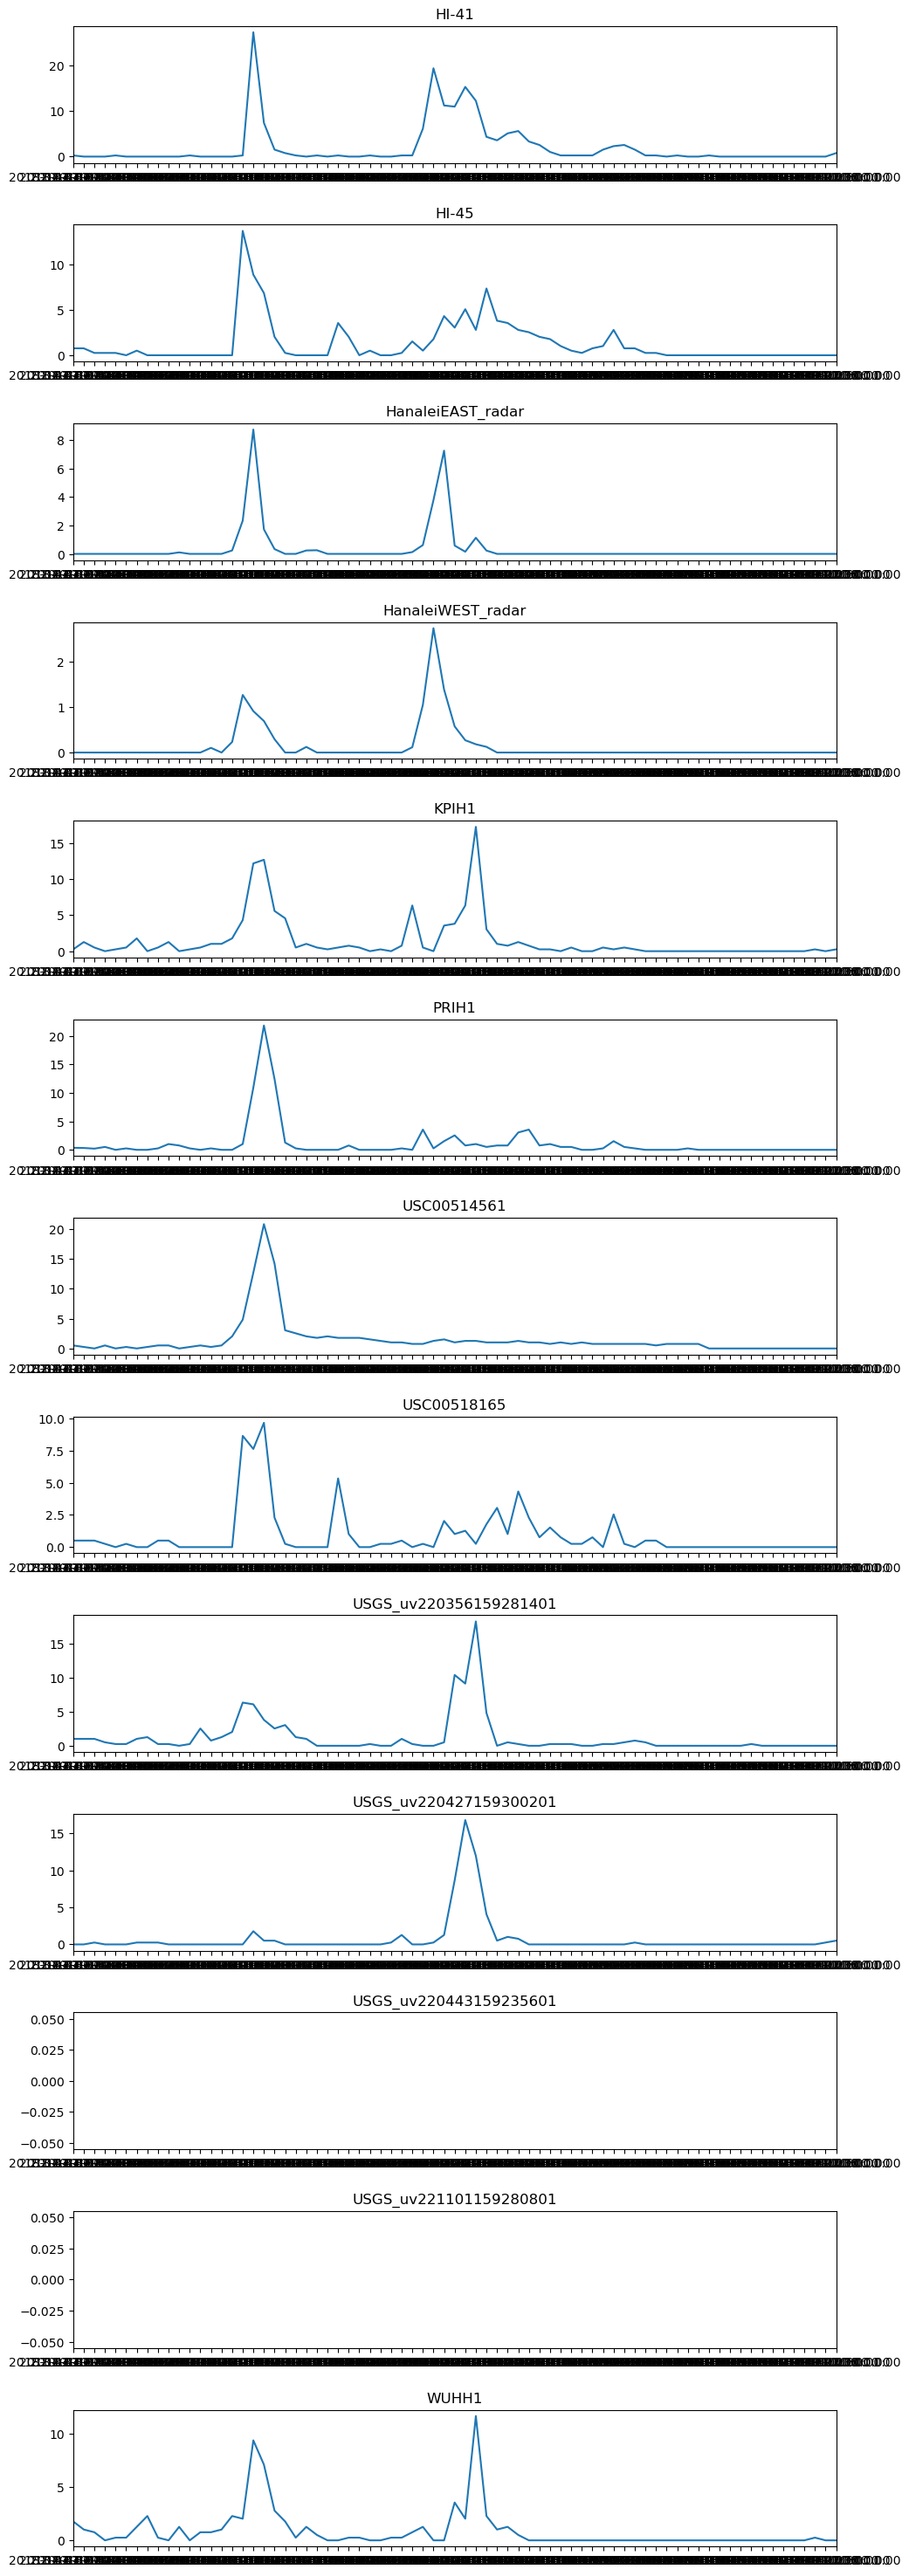

In [13]:
gages_names = (gages_data.columns.tolist())[2:]

fig, axs= plt.subplots(len(gages_names), figsize=(10,30))
fig.tight_layout(pad=3.0)

for i in range(0, len(gages_names)):
    axs[i].plot(gages_data['DateTime'], gages_data[gages_names[i]])
    axs[i].set_title(gages_names[i])
    axs[i].set_xlim((gages_data['DateTime'].min()), (gages_data['DateTime'].max()))

# Export Data

In [14]:
gages_data.to_csv(all_rain_gages_data[:-4] + 'filled_NA.csv')